<a href="https://colab.research.google.com/github/diyosukma/CP68-SistemRekomendasi/blob/main/Collaborative_Filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [73]:
import pandas as pd
import numpy as np
import nltk
#nltk.download()
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')
#nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
import re
import string
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import NearestNeighbors

In [74]:
eskul = pd.read_excel('eskul.xlsx')
mbtes = pd.read_excel('mbtes.xlsx')
nilai = pd.read_excel('hasilmb.xlsx')

In [52]:
eskul

,user_id,nama,asal_sekolah,sulit_memilih,gender,agama,jurusan,bidang_eskul,bidang_id,pekerjaan_ibu,pekerjaan_bapak,sungguh_berkegiatan,minatbakat_tersalurkan,alasan_memilih,teman_berpengaruh,lama_pertemuan,banyak_pertemuan
0,10,Siswa01,SMA Negeri 5 Sukabumi,Tidak,Laki-laki,Islam,IPS,Kesenian,1,Ibu Rumah Tangga,Wiraswasta,Ya,Ya,Tekad dari diri sendiri,Ya,Lebih dari 1 Jam,2 Kali Seminggu
1,20,Siswa02,SMA Negeri 5 Sukabumi,Tidak,Laki-laki,Islam,IPS,Olahraga,2,Ibu Rumah Tangga,Wiraswasta,Ya,Ya,Tekad dari diri sendiri,Ya,Lebih dari 1 Jam,2 Kali Seminggu
2,30,Siswa03,SMA Negeri 1 Kota Sukabumi,Tidak,Perempuan,Islam,IPA,Akademik & Kebahasaan,3,Ibu rumah tangga,PNS,Ya,Ya,Tekad dari diri sendiri,Ya,1 Jam,1 Kali Seminggu
3,40,Siswa04,SMAN 1CIBADAK,Tidak,Perempuan,Islam,IPA,Olahraga,2,PNS,PNS,Ya,Ya,Tekad dari diri sendiri,Tidak,Lebih dari 1 Jam,2 Kali Seminggu
4,50,Siswa05,SMAN 1CIBADAK,Tidak,Perempuan,Islam,IPA,Kesenian,1,PNS,PNS,Ya,Ya,Tekad dari diri sendiri,Tidak,Lebih dari 1 Jam,2 Kali Seminggu
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288,2890,Siswa289,SMA 1 Semarang,Tidak,Perempuan,Islam,IPS,Lingkungan Hidup,6,IRT,Sopir,Ya,Ya,Tekad dari diri sendiri,Ya,Lebih dari 1 Jam,1 Kali Seminggu
289,2900,Siswa290,SMA 1 Surakarta,Ya,Laki-laki,Kristen Protestan,IPA,Akademik & Kebahasaan,3,IRT,Karyawan perusahaan,Ya,Ya,Tekad dari diri sendiri,Ya,Lebih dari 1 Jam,2 Kali Seminggu
290,2910,Siswa291,SMA 1 Surakarta,Ya,Laki-laki,Kristen Protestan,IPA,IT,5,IRT,Karyawan perusahaan,Ya,Ya,Tekad dari diri sendiri,Ya,Lebih dari 1 Jam,2 Kali Seminggu
291,2920,Siswa292,SMA 6 Jakarta,Ya,Perempuan,Kristen Katolik,IPA,Akademik & Kebahasaan,3,Ibu rumah tangga,Pegawai bank,Ya,Ya,Tekad dari diri sendiri,Ya,Lebih dari 1 Jam,1 Kali Seminggu


In [53]:
#Mengecek dan mengembalikan type data.
def getEskulFrame(eskul):
    if isinstance(eskul, int):
        return eskul[eskul.user_id == eskul]
    if isinstance(eskul, str):
        return eskul[eskul.nama == eskul]

In [54]:
mbtes

,mb_id,nama,minat_bakat
0,5,Siswa01,Cenderung menyukai untuk bekerja secara berkel...
1,10,Siswa02,Cenderung menyukai untuk bekerja secara berkel...
2,15,Siswa03,"Menggemari kegiatan yang melibatkan tulisan, M..."
3,20,Siswa04,Mempertimbangkan baik sisi plus ataupun minus ...
4,25,Siswa05,Mempertimbangkan baik sisi plus ataupun minus ...
...,...,...,...
288,1445,Siswa289,Gemar menuangkan ide dalam bentuk tulisan atau...
289,1450,Siswa290,"Menggemari kegiatan yang melibatkan tulisan, M..."
290,1455,Siswa291,"Menggemari kegiatan yang melibatkan tulisan, M..."
291,1460,Siswa292,Gemar menuangkan ide dalam bentuk tulisan atau...


In [55]:
# Mengecek dan mengembalikan type data,
def getBidang(eskul):
    if isinstance(eskul, int):
        return mbtes[mbtes.mb_id == eskul].minat_bakat.values[0]
    if isinstance(eskul, str):
        return mbtes[mbtes.nama == eskul].minat_bakat.values[0]

In [75]:
nilai

,user_id,nama,jumlah,rata-rata,bidang_eskul,bidang_id
0,10,Siswa01,8,0.166667,Kesenian,1
1,20,Siswa02,8,0.166667,Olahraga,2
2,30,Siswa03,5,0.104167,Akademik & Kebahasaan,3
3,40,Siswa04,12,0.250000,Olahraga,2
4,50,Siswa05,12,0.250000,Kesenian,1
...,...,...,...,...,...,...
288,2890,Siswa289,17,0.354167,Lingkungan Hidup,6
289,2900,Siswa290,17,0.354167,Akademik & Kebahasaan,3
290,2910,Siswa291,17,0.354167,IT,5
291,2920,Siswa292,17,0.354167,Akademik & Kebahasaan,3


In [76]:
# Menghitung user yang memberi menjawab>1
n_nilai = nilai['user_id'].value_counts()


In [77]:
# Encoding categorical data
# Mrnghitung data dari user.
# Melihat min_max nilai
user_ids = nilai["user_id"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
user_encoded2user = {i: x for i, x in enumerate(user_ids)}
nilai["user"] = nilai["user_id"].map(user2user_encoded)
n_users = len(user2user_encoded)

bidang_ids = nilai["bidang_id"].unique().tolist()
bidang2bidang_encoded = {x: i for i, x in enumerate(bidang_ids)}
bidang_encoded2bidang = {i: x for i, x in enumerate(bidang_ids)}
nilai["bidang_eskul"] = nilai["bidang_id"].map(bidang2bidang_encoded)
n_bidang = len(bidang2bidang_encoded)

print("Num of users: {}, Num of bidang eskul: {}".format(n_users, n_bidang))
print("Min nilai: {}, Max nilai: {}".format(min(nilai['jumlah']), max(nilai['jumlah'])))

Num of users: 293, Num of bidang eskul: 6
Min nilai: 1, Max nilai: 46


In [78]:
# Menghitung rata2 nilai
min_nilai = min(nilai['jumlah'])
max_nilai = max(nilai['jumlah'])
nilai['jumlah'] = nilai["jumlah"].apply(lambda x: (x - min_nilai) / (max_nilai - min_nilai)).values.astype(np.float64)

Avgnilai = np.mean(nilai['jumlah'])
print('Avg', Avgnilai)

Avg 0.32172923777019335


In [79]:
g = nilai.groupby('user_id')['jumlah'].count()
top_users = g.dropna().sort_values(ascending=False)[:6]
top_r = nilai.join(top_users, rsuffix='_r', how='inner', on='user_id')

g = nilai.groupby('bidang_id')['jumlah'].count()
top_bidang= g.dropna().sort_values(ascending=False)[:6]
top_r = top_r.join(top_bidang, rsuffix='_r', how='inner', on='bidang_id')

pd.crosstab(top_r.user_id, top_r.bidang_id, top_r.jumlah, aggfunc=np.sum)

bidang_id,1,3,4,5,6
user_id,,,,,
930,0.222222,NaN,NaN,NaN,NaN
940,NaN,NaN,0.333333,NaN,NaN
950,0.333333,NaN,NaN,NaN,NaN
960,NaN,0.133333,NaN,NaN,NaN
1090,NaN,NaN,NaN,NaN,0.355556
2930,NaN,NaN,NaN,0.355556,NaN


In [80]:
nilai.isnull().sum()

user_id         0
nama            0
jumlah          0
rata-rata       0
bidang_eskul    0
bidang_id       0
user            0
dtype: int64

In [82]:
# Mengacak data
nilai = nilai.sample(frac=1, random_state=2021)

X = nilai[['user', 'bidang_eskul']].values
y = nilai["jumlah"]

In [83]:
# Split data
# disini saya mengambil 10000 untuk test set

test_set_size = 70 #10k for test set
train_indices = nilai.shape[0] - test_set_size 

X_train, X_test, y_train, y_test = (
    X[:train_indices],
    X[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

print('> Train set ratings: {}'.format(len(y_train)))
print('> Test set ratings: {}'.format(len(y_test)))

> Train set ratings: 223
> Test set ratings: 70


In [84]:
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [85]:
# Accelerator check
# Disini saya menggunakan TPU bukan GPU untuk proses melatih model 
# Tensor Processing Unit (TPU).
import tensorflow as tf

TPU_INIT = True

if TPU_INIT:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    !nvidia-smi
    
print(tf.__version__)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.68.111.74:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.68.111.74:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


2.7.0


In [86]:
# Import Library yang dibutuhkan

import keras
from keras import layers 
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [87]:
# Embedding layers

from keras.layers import Add, Activation, Lambda, BatchNormalization, Concatenate, Dropout, Input, Embedding, Dot, Reshape, Dense, Flatten

def RecommenderNet():
    embedding_size = 128
    
    user = Input(name = 'user', shape = [1])
    user_embedding = Embedding(name = 'user_embedding',
                       input_dim = n_users, 
                       output_dim = embedding_size)(user)
    
    bidang_eskul = Input(name = 'bidang_eskul', shape = [1])
    bidang_embedding = Embedding(name = 'bidang_embedding',
                       input_dim = n_bidang, 
                       output_dim = embedding_size)(bidang_eskul)
    
    #x = Concatenate()([user_embedding, anime_embedding])
    x = Dot(name = 'dot_product', normalize = True, axes = 2)([user_embedding, bidang_embedding])
    x = Flatten()(x)
        
    x = Dense(1, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation("sigmoid")(x)
    
    model = Model(inputs=[user, bidang_eskul], outputs=x)
    model.compile(loss='binary_crossentropy', metrics=["mae", "mse"], optimizer='Adam')
    
    return model

if TPU_INIT:    
    with tpu_strategy.scope():
        model = RecommenderNet()
else:
    model = RecommenderNet()

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 bidang_eskul (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 128)       37504       ['user[0][0]']                   
                                                                                                  
 bidang_embedding (Embedding)   (None, 1, 128)       768         ['bidang_eskul[0][0]']           
                                                                                            

In [97]:
# Callbacks
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau

start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005
batch_size = 5

if TPU_INIT:
    max_lr = max_lr * tpu_strategy.num_replicas_in_sync
    batch_size = batch_size * tpu_strategy.num_replicas_in_sync

rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

def lrfn(epoch):
    if epoch < rampup_epochs:
        return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr


lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=0)

checkpoint_filepath = './weights.h5'

model_checkpoints = ModelCheckpoint(filepath=checkpoint_filepath,
                                        save_weights_only=True,
                                        monitor='val_loss',
                                        mode='min',
                                        save_best_only=True)

early_stopping = EarlyStopping(patience = 3, monitor='val_loss', 
                               mode='min', restore_best_weights=True)

my_callbacks = [
    model_checkpoints,
    lr_callback,
    early_stopping,   
]

In [98]:
# Model training
history = model.fit(
    x=X_train_array,
    y=y_train,
    batch_size=batch_size,
    epochs=50,
    verbose=1,
    validation_data=(X_test_array, y_test),
    callbacks=my_callbacks
)

model.load_weights(checkpoint_filepath)

Epoch 1/50
6/6 [==============================] - 3s 494ms/step - loss: 0.8157 - mae: 0.2481 - mse: 0.0964 - val_loss: 0.7051 - val_mae: 0.1824 - val_mse: 0.0474 - lr: 1.0000e-05
Epoch 2/50
6/6 [==============================] - 1s 192ms/step - loss: 0.8055 - mae: 0.2528 - mse: 0.0931 - val_loss: 0.7057 - val_mae: 0.1826 - val_mse: 0.0477 - lr: 8.8000e-05
Epoch 3/50
6/6 [==============================] - 1s 190ms/step - loss: 0.8048 - mae: 0.2490 - mse: 0.0930 - val_loss: 0.7062 - val_mae: 0.1826 - val_mse: 0.0479 - lr: 1.6600e-04
Epoch 4/50
6/6 [==============================] - 1s 222ms/step - loss: 0.7934 - mae: 0.2338 - mse: 0.0879 - val_loss: 0.7065 - val_mae: 0.1824 - val_mse: 0.0481 - lr: 2.4400e-04


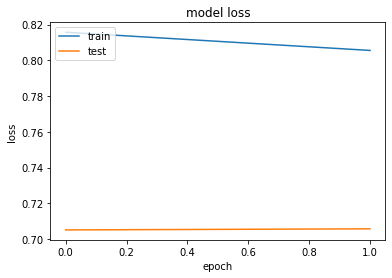

In [99]:
# Training results
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history.history["loss"][0:-2])
plt.plot(history.history["val_loss"][0:-2])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [100]:
# proses ekstrak weight data/reshape
def extract_weights(name, model):
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    weights = weights / np.linalg.norm(weights, axis = 1).reshape((-1, 1))
    return weights

bidang_weights = extract_weights('bidang_embedding', model)
user_weights = extract_weights('user_embedding', model)

In [155]:
# pd.reset_option('all')
pd.set_option("max_colwidth", None)

def find_similar_user(name, n=10, return_dist=False, neg=False):
    try:
        index = getEskulFrame(name).user_id.values[0]
        encoded_index = bidang2bidang_encoded.get(index)
        weights = bidang_weights
        
        dists = np.dot(weights, weights[encoded_index])
        sorted_dists = np.argsort(dists)
        
        n = n + 1            
        
        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]

        print('user closest to {}'.format(name))

        if return_dist:
            return dists, closest
        
        rindex = eskul

        SimilarityArr = []

        for close in closest:
            decoded_id = bidang_encoded2bidang.get(close)
            minat_bakat = getBidang(decoded_id)
            eskul_frame = getEskulFrame(decoded_id)
            
            nama = eskul_frame.nama.values[0]
            bidang_eskul = eskul_frame.bidang_eskul.values[0]
            similarity = dists[close]
            SimilarityArr.append({"user_id": decoded_id, "nama": nama,
                                  "similarity": similarity,"bidang_eskul": bidang_eskul,
                                  'minat_bakat': minat_bakat})

        Frame = pd.DataFrame(SimilarityArr).sort_values(by="similarity", ascending=False)
        return Frame[Frame.user_id != index].drop(['user_id'], axis=1)

    except:
        print('{}!, Not Found in list'.format(name))

In [160]:
find_similar_user('Ini masih error', n=10, neg=False)

Ini masih error!, Not Found in list


In [161]:
print('> Cari acak user')

nilai_per_user = nilai.groupby('user_id').size()
random_user = nilai_per_user[nilai_per_user < 10].sample(1, random_state=None).index[0]
print('> user_id:', random_user)

> Cari acak user
> user_id: 1380


In [164]:
# pd.reset_option('all')
pd.set_option("max_colwidth", None)

def find_similar_users(item_input, n=10,return_dist=False, neg=False):
    try:
        index = item_input
        encoded_index = user2user_encoded.get(index)
        weights = user_weights
    
        dists = np.dot(weights, weights[encoded_index])
        sorted_dists = np.argsort(dists)
        
        n = n + 1
        
        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]

        print('> users similar to #{}'.format(item_input))

        if return_dist:
            return dists, closest
        
        rindex = eskul
        SimilarityArr = []
        
        for close in closest:
            similarity = dists[close]

            if isinstance(item_input, int):
                decoded_id = user_encoded2user.get(close)
                SimilarityArr.append({"similar_users": decoded_id, 
                                      "similarity": similarity})

        Frame = pd.DataFrame(SimilarityArr).sort_values(by="similarity", 
                                                        ascending=False)
        
        return Frame
    
    except:
        print('{}!, Not Found in User list'.format(name))

In [168]:
# menemukan user yang similar dengan random user
similar_users = find_similar_users(int(random_user), 
                                   n=5, 
                                   neg=False)

similar_users = similar_users[similar_users.similarity > 0.2]
similar_users = similar_users[similar_users.similar_users != random_user]
similar_users.head(5)

> users similar to #1380


,similar_users,similarity
4,890,0.215059
3,2870,0.210478
